In [1]:
import pandas as pd
import glob
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
csv_files = glob.glob("./*.csv")  # 获取所有CSV文件路径
print(csv_files)

['./submission.csv', './test.csv', './train.csv']


In [3]:
test_y = pd.read_csv(csv_files[0])
test = pd.read_csv(csv_files[1])
train = pd.read_csv(csv_files[2])
test["Survived"] = test_y["Survived"]

print(f"表头: {train.columns}")
print(f"数据维度: {train.shape}") # 行数中不会计入表头


表头: Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
数据维度: (891, 12)


In [4]:
# 打印前5行数据以了解该数据集的基本信息
print(train.head())

   PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare Cabin Embarked  
0      0         A/5 21171   7.2500   NaN        S  
1      0          PC 17599  71.2833   C85        C  
2      0  STON/O2. 3101282   7.9250   NaN        S  
3      0            113803  53.1000  C123        S  
4      0            373450   8.0500   NaN        S  


In [5]:
print(f"训练集数据的基本信息:")
train.info()
print("\n")
print("数据集的缺失值信息:")
print(train.isnull().sum())


训练集数据的基本信息:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


数据集的缺失值信息:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked  

从以上信息可以看出，该训练集中存在缺失值，其中 `Age` 存在 177 个缺失值，`Cabin` 存在 687 个缺失值，`Embarked` 存在2个缺失值。

In [6]:
print("训练集数据的统计统计:")
print(train.describe())

训练集数据的统计统计:
       PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
count  891.000000  891.000000  
mean     0.381594   32.204208  
std      0.806057   49.693429  
min      0.000000    0.000000  
25%      0.000000    7.910400  
50%      0.000000   14.454200  
75%      0.000000   31.000000  
max      6.000000  512.329200  


可以使用箱线图的思想来对离群点进行检测，箱线图的原理是：首先找出数据集中的上四分位数（Q3）和下四分位数（Q1），然后计算出四分位数间距（IQR=Q3-Q1），最后定义上下限为Q3+1.5IQR和Q1-1.5IQR，超出上下限的数据点即为离群点。

In [7]:
numeric_train = train.select_dtypes(include=['int64', 'float64'])
outliers_dict = {}

for i in numeric_train.columns:
    Q1 = train[i].quantile(0.25)
    Q3 = train[i].quantile(0.75)
    IQR = Q3 - Q1

    # 定义上下限
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # 检测异常值
    outliers = train[(train[i] < lower_bound) | (train[i] > upper_bound)]
    outliers_dict[i] = outliers[i]  # 将异常值加入字典


for col, outliers in outliers_dict.items():
        print(f"列 {col} 的异常值数量: {len(outliers)}")

列 PassengerId 的异常值数量: 0
列 Survived 的异常值数量: 0
列 Pclass 的异常值数量: 0
列 Age 的异常值数量: 11
列 SibSp 的异常值数量: 46
列 Parch 的异常值数量: 213
列 Fare 的异常值数量: 116


为了计算每个变量和生存率的关系，最简单的方法可以使用皮尔逊相关系数。

In [8]:
# 计算生存率与其他数值变量的皮尔逊相关系数
pearson_corr = numeric_train.corr()['Survived'].sort_values(ascending=False)
print("各变量与生存率的皮尔逊相关系数：\n", pearson_corr)

各变量与生存率的皮尔逊相关系数：
 Survived       1.000000
Fare           0.257307
Parch          0.081629
PassengerId   -0.005007
SibSp         -0.035322
Age           -0.077221
Pclass        -0.338481
Name: Survived, dtype: float64


从皮尔逊相关系数可以看出，生存率与票价和舱位等级有着一定的相关性，可以理解为票价越高，舱位等级越高，生存率越高。进一步的，我们可以单独分析其他几个比较重要的变量与生存率的关系，首先是性别。

Sex     Survived
female  0            81
        1           233
male    0           468
        1           109
Name: Survived, dtype: int64


<Figure size 800x600 with 0 Axes>

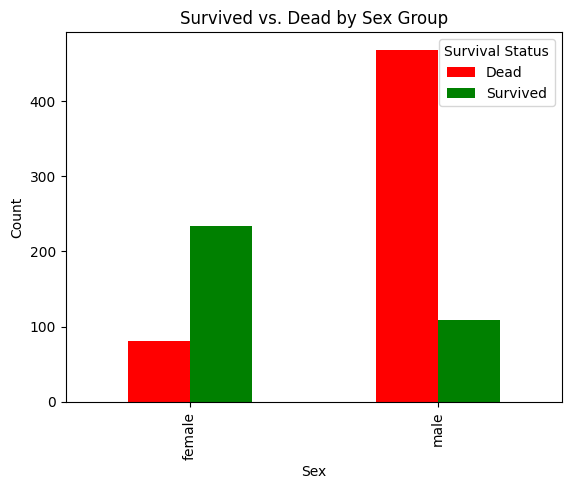

In [9]:
print(train.groupby(['Sex','Survived'])['Survived'].count())
group_by_sex = train.groupby(['Sex', 'Survived']).size().unstack()
plt.figure(figsize=(8, 6))
group_by_sex.plot(kind='bar', stacked=False, color=['red', 'green'])
plt.title('Survived vs. Dead by Sex Group')
plt.xlabel('Sex')
plt.ylabel('Count')
plt.legend(['Dead', 'Survived'], title='Survival Status')
plt.show()

其次是年龄。

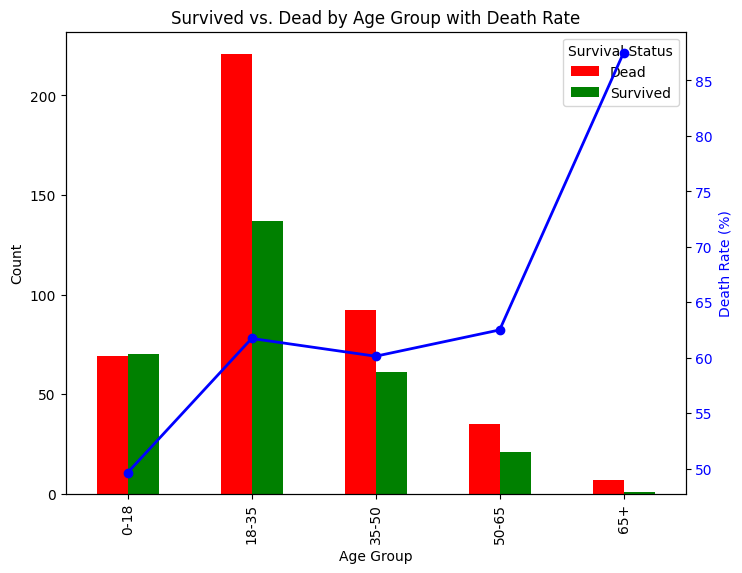

In [10]:
# 将年龄划分为几个区间
age_bins = [0, 18, 35, 50, 65, 80]
age_labels = ['0-18', '18-35', '35-50', '50-65', '65+']
train['AgeGroup'] = pd.cut(train['Age'], bins=age_bins, labels=age_labels)
# 按年龄组和生存状态分组，计算生存和死亡人数
group_by_age = train.groupby(['AgeGroup', 'Survived']).size().unstack()
train.drop(columns=["AgeGroup"], inplace=True)
# 计算死亡率
group_by_age['Death Rate'] = group_by_age[0] / (group_by_age[0] + group_by_age[1]) * 100
# 绘制生存和死亡人数的条形图
fig, ax1 = plt.subplots(figsize=(8, 6))
group_by_age[[0, 1]].plot(kind='bar', stacked=False, color=['red', 'green'], ax=ax1)
ax1.set_title('Survived vs. Dead by Age Group with Death Rate')
ax1.set_xlabel('Age Group')
ax1.set_ylabel('Count')
ax1.legend(['Dead', 'Survived'], title='Survival Status')
# 绘制死亡率的折线图
ax2 = ax1.twinx()
ax2.plot(group_by_age.index, group_by_age['Death Rate'], color='blue', marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel('Death Rate (%)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
plt.show()

从这幅图可以看出，死亡率随年龄的增加总体呈上升趋势，结合刚刚对性别的分析，可以看出乘客在逃生时遵循了一定的道德良知，让妇女和儿童先走。下面可以分析在船兄弟姐妹或配偶数量与死亡率之间的关系。

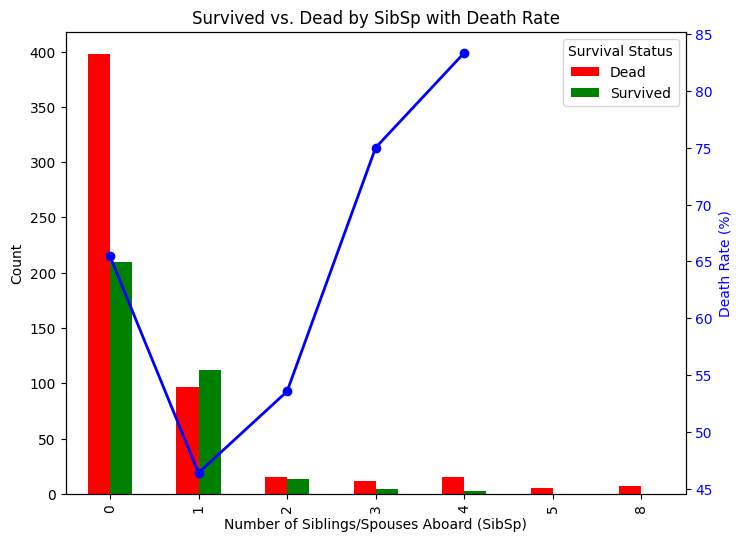

In [11]:

# 按兄弟姐妹或配偶数量（SibSp）分组，计算生存和死亡人数
group_by_sibsp = train.groupby(['SibSp', 'Survived']).size().unstack()
# 计算死亡率
group_by_sibsp['Death Rate'] = group_by_sibsp[0] / (group_by_sibsp[0] + group_by_sibsp[1]) * 100
# 绘制生存和死亡人数的条形图
fig, ax1 = plt.subplots(figsize=(8, 6))
group_by_sibsp[[0, 1]].plot(kind='bar', stacked=False, color=['red', 'green'], ax=ax1)
ax1.set_title('Survived vs. Dead by SibSp with Death Rate')
ax1.set_xlabel('Number of Siblings/Spouses Aboard (SibSp)')
ax1.set_ylabel('Count')
ax1.legend(['Dead', 'Survived'], title='Survival Status')
# 绘制死亡率的折线图
ax2 = ax1.twinx()
ax2.plot(group_by_sibsp.index, group_by_sibsp['Death Rate'], color='blue', marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel('Death Rate (%)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
plt.show()

从图中可以看出，`SibSp` 为 1 时，死亡率最低。下面分析在船父母或孩子数量的影响。

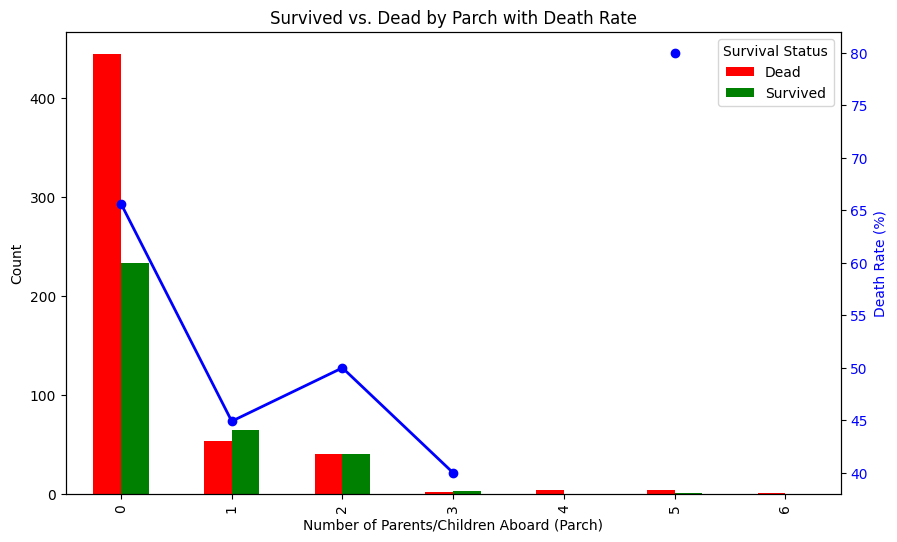

In [12]:
# 按父母或孩子数量（Parch）分组，计算生存和死亡人数
group_by_parch = train.groupby(['Parch', 'Survived']).size().unstack()
# 计算每个父母或孩子数量分组的死亡率
group_by_parch['Death Rate'] = group_by_parch[0] / (group_by_parch[0] + group_by_parch[1]) * 100
# 绘制生存和死亡人数的条形图
fig, ax1 = plt.subplots(figsize=(10, 6))
group_by_parch[[0, 1]].plot(kind='bar', stacked=False, color=['red', 'green'], ax=ax1)
ax1.set_title('Survived vs. Dead by Parch with Death Rate')
ax1.set_xlabel('Number of Parents/Children Aboard (Parch)')
ax1.set_ylabel('Count')
ax1.legend(['Dead', 'Survived'], title='Survival Status')
# 绘制死亡率的折线图
ax2 = ax1.twinx()
ax2.plot(group_by_parch.index, group_by_parch['Death Rate'], color='blue', marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel('Death Rate (%)', color='blue')
ax2.tick_params(axis='y', labelcolor='blue')
plt.show()

从图中可以看出，`Parch` 为 1 时，死亡率较低。由于到 `Cabin` 列缺失数据较多，我们不对该特征进行分析，并故考虑直接将该列删除。进一步的，我们可以思考该数据集中哪些列对我们通过构建神经网络来预测乘客是否生还是有用的信息。显然，PassengerId、Name、Ticket 这三列对我们的预测没有帮助，故可以考虑删除他们。为了便于使用乘客的性别以及登船港口数据，我们可以将 `Sex` 列的值转换为数值类型，其中 `male` 转换为 1，`female` 转换为 0; `Embarked` 列的值转换为数值类型，其中 `S` 转换为 0，`C` 转换为 1，`Q` 转换为 2。

In [13]:
train.drop(columns=["Cabin", "PassengerId", "Name", "Ticket"], inplace=True)
test.drop(columns=["Cabin", "PassengerId", "Name", "Ticket"], inplace=True)
train['Sex'] = train['Sex'].map({'male': 1, 'female': 0})
test['Sex'] = test['Sex'].map({'male': 1, 'female': 0})
train['Embarked'] = train['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
test['Embarked'] = test['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
print(train.head())

   Survived  Pclass  Sex   Age  SibSp  Parch     Fare  Embarked
0         0       3    1  22.0      1      0   7.2500       0.0
1         1       1    0  38.0      1      0  71.2833       1.0
2         1       3    0  26.0      0      0   7.9250       0.0
3         1       1    0  35.0      1      0  53.1000       0.0
4         0       3    1  35.0      0      0   8.0500       0.0


在进行神经网络的训练之前，先填补缺失值。

In [14]:
# 处理缺失值
train['Age'].fillna(train['Age'].median(), inplace=True)
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace=True)
test['Age'].fillna(test['Age'].median(), inplace=True)
test['Fare'].fillna(test['Fare'].median(), inplace=True)
test['Embarked'].fillna(test['Embarked'].mode()[0], inplace=True)

# 标准化特征，保证分布的一致性
scaler = StandardScaler()
X_train = scaler.fit_transform(train.drop(columns=["Survived"]).values)
X_test = scaler.transform(test.drop(columns=["Survived"]).values)

X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(train["Survived"].values, dtype=torch.float32).unsqueeze(1)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(test["Survived"].values, dtype=torch.float32).unsqueeze(1)


至此，训练集的数据预处理已经全部结束，接下来可以构建神经网络并拟合训练集。

In [15]:
class TitanicMLP(nn.Module):
    def __init__(self, input_dim=7, hidden_dim=64, dropout=0.1):
        super().__init__()

        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim // 2, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [16]:
from torch.utils.data import DataLoader, TensorDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# 定义训练有关的超参数
dim = X_train.shape[-1]
hidden_dim = 64
dropout = 0.5
num_epochs = 50
lr = 1e-3
batch_size = 32

# 定义数据集和数据加载器
train_dataset = TensorDataset(X_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = TensorDataset(X_test)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# 初始化模型及优化器
model = TitanicMLP(input_dim=dim, hidden_dim=hidden_dim, dropout=dropout)
model = model.to(device)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr) 


Using device: cuda


Epoch [10/50], Average Loss: 0.4630
Epoch [20/50], Average Loss: 0.4497
Epoch [30/50], Average Loss: 0.4598
Epoch [40/50], Average Loss: 0.4316
Epoch [50/50], Average Loss: 0.4131


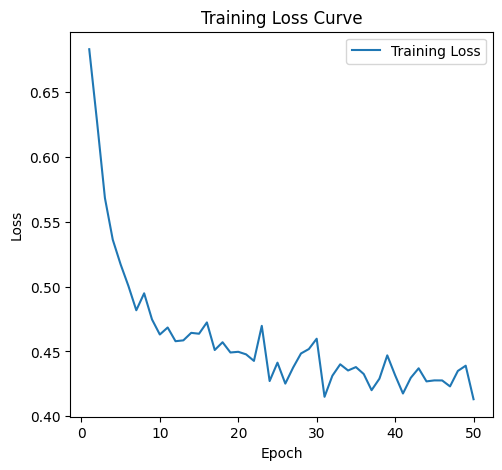

In [17]:
# 训练模型
model.train()
losses = []

for epoch in range(num_epochs):
    running_loss = 0.0
    correct = 0
    total = 0

    for idx, (x, y) in enumerate(train_dataloader):
        x, y = x.to(device), y.to(device)

        output = model(x)
        loss = criterion(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 累加损失
        running_loss += loss.item()

        # 计算准确率
        _, predicted = torch.max(output, 1)  # 获取预测类别
        total += y.size(0)
        correct += (predicted == y).sum().item()

    # 计算并存储每个 epoch 的平均损失和准确率
    epoch_loss = running_loss / len(train_dataloader)
    losses.append(epoch_loss)

    if (epoch + 1) % 10 == 0:
        print(f"Epoch [{epoch + 1}/{num_epochs}], Average Loss: {epoch_loss:.4f}")

# 绘制损失和准确率曲线
plt.figure(figsize=(12, 5))

# 绘制损失曲线
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()

plt.show()

In [18]:
# 模型预测
model.eval()
predictions = []
with torch.no_grad():
    for x in test_dataloader:
        x = x[0].to(device)
        output = model(x)
        prediction = (output > 0.5).int()
        predictions.append(prediction)

predictions = torch.cat(predictions,dim=0).cpu()
acc = accuracy_score(y_test, predictions)
print(f"Accuracy: {acc:.4f}")


Accuracy: 0.7871
